# Processing inputs for the Dynamic Benthic Pelagic Model (DBPM)
**Author:** Denisse Fierro Arcos  
**Date:** 2024-10-10  
  
We will use GFDL-MOM6-COBALT2 (referred to as GFDL from now on) outputs at two horizontal resolutions: 0.25$^{\circ}$ (original grid) and 1$^{\circ}$ (coarsen from original grid) to force the Dynamic Benthic Pelagic Model (DBPM).  

DBPM requires the seven inputs, some of which are directly available as outputs in GFDL, while others need to be calculated from available GFDL outputs:  
- depth (`deptho` in GFDL)  
- small phytoplankton (`phypico-vint` or mole concentration of picoplankton expressed as carbon in sea water in GFDL)  
- large phytoplankton: This variable is not directly available in GFDL, but it can be calculated by substracting small phytoplankton (`phypico-vint` in GFDL) from total phytoplankton (`phyc-vint` or phytoplankton carbon concentration in GFDL)  
- sea surface temperature (`tos` in GFDL)  
- bottom ocean temperature (`tob` in GFDL)  
- detritus (`expc-bot` or downward flux of particulate organic carbon in GFDL)
- export ratio: This variable is estimated from small phytoplankton, large phytoplankton, sea surface temperature and depth using the `getExportRatio` function  

Finally, we will create a spinup using the first 20 years of data available in the `ctrlclim` outputs. We will repeat data for this period six times for a spinup period of 120 years.  
  
All variables will be processed at a global scale and they will be stored in `zarr` format so they can be easily accessed when running DBPM.  

## Loading relevant libraries

In [1]:
import os
os.chdir('/g/data/vf71/la6889/lme_scale_calibration_ISMIP3a/new_workflow/')

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from glob import glob
from dask.distributed import Client
import useful_functions as uf

## Start a cluster

In [ ]:
client = Client(threads_per_worker = 1)
client

## Load relevant GFDL-MOM6-COBALT2 outputs

In [3]:
#Base folder where GFDL outputs are stored - obsclim and ctrlclim
gfdl_obsclim = '/g/data/vf71/fishmip_inputs/ISIMIP3a/global_inputs/obsclim/025deg'
gfdl_ctrlclim = '/g/data/vf71/fishmip_inputs/ISIMIP3a/global_inputs/ctrlclim/025deg'
#Variables of interest
dbpm_var = ['deptho', 'expc-bot', 'phyc-vint', 'phypico-vint', 'tob', 'tos']
#List of relevant files
gfdl_obs_files = [glob(os.path.join(gfdl_obsclim, f'*_{var}_*'))[0] for var in dbpm_var]
gfdl_ctrl_files = [glob(os.path.join(gfdl_ctrlclim, f'*_{var}_*'))[0] for var in dbpm_var]

## Define location of outputs

In [3]:
gfdl_out = '/g/data/vf71/la6889/dbpm_inputs/global_gridded/'
os.makedirs(gfdl_out, exist_ok = True)

## Saving `netcdf` files as `zarr` files

### `obsclim`

In [5]:
for f in gfdl_obs_files:
    #Create file path to save outputs
    f_out = os.path.basename(f).replace('.nc', '.zarr')
    f_out = os.path.join(gfdl_out, f_out)
    #Apply function
    uf.netcdf_to_zarr(f, f_out)

### `ctrlclim`

In [8]:
for f in gfdl_ctrl_files:
    #Create file path to save outputs
    f_out = os.path.basename(f).replace('.nc', '.zarr')
    f_out = os.path.join(gfdl_out, f_out)
    #Apply function
    uf.netcdf_to_zarr(f, f_out)

### Area of the grid cell (`areacello`)

In [9]:
area_path = '/g/data/vf71/shared_resources/grid_cell_area_ESMs/isimip3a/gfdl-mom6-cobalt2_areacello_15arcmin_global_fixed.nc'
file_out = os.path.basename(area_path).replace('.nc', '.zarr')
file_out = os.path.join(gfdl_out, file_out)
uf.netcdf_to_zarr(area_path, file_out)

## Calculating phytoplankton (large and small) and export ratio

In [24]:
#Calculating from ctrlclim data
gfdl_exp = 'ctrlclim'
sphy_ctrl, lphy_ctrl, er_ctrl = uf.getExportRatio(gfdl_out, gfdl_exp)

In [25]:
#Saving datasets
sphy_ctrl.to_zarr(
    os.path.join(gfdl_out, 
                 f'gfdl-mom6-cobalt2_{gfdl_exp}_sphy_15arcmin_global_monthly_1961_2010.zarr'),
          consolidated = True, mode = 'w')

lphy_ctrl.to_zarr(
    os.path.join(gfdl_out, 
                 f'gfdl-mom6-cobalt2_{gfdl_exp}_lphy_15arcmin_global_monthly_1961_2010.zarr'),
          consolidated = True, mode = 'w')

er_ctrl.to_zarr(
    os.path.join(gfdl_out, 
                 f'gfdl-mom6-cobalt2_{gfdl_exp}_er_15arcmin_global_monthly_1961_2010.zarr'),
          consolidated = True, mode = 'w')

In [26]:
#Calculating from obsclim data
gfdl_exp = 'obsclim'
sphy_obs, lphy_obs, er_obs = uf.getExportRatio(gfdl_out, gfdl_exp)

## Calculate intercept and slope

### `obsclim`

In [17]:
int_obs, slope_obs = uf.GetPPIntSlope(
    glob(os.path.join(gfdl_out, '*obsclim*')))

#Saving datasets
int_obs.to_zarr(
    os.path.join(gfdl_out, 
                 'gfdl-mom6-cobalt2_obsclim_intercept_15arcmin_global_monthly_1961_2010.zarr'),
          consolidated = True, mode = 'w')

slope_obs.to_zarr(
    os.path.join(gfdl_out, 
                 'gfdl-mom6-cobalt2_obsclim_slope_15arcmin_global_monthly_1961_2010.zarr'),
          consolidated = True, mode = 'w')

### `ctrlclim`

In [18]:
int_ctrl, slope_ctrl = uf.GetPPIntSlope(
    glob(os.path.join(gfdl_out, '*ctrlclim*')))

#Saving datasets
int_ctrl.to_zarr(
    os.path.join(gfdl_out, 
                 'gfdl-mom6-cobalt2_ctrlclim_intercept_15arcmin_global_monthly_1961_2010.zarr'),
          consolidated = True, mode = 'w')

slope_ctrl.to_zarr(
    os.path.join(gfdl_out, 
                 'gfdl-mom6-cobalt2_ctrlclim_slope_15arcmin_global_monthly_1961_2010.zarr'),
          consolidated = True, mode = 'w')

## Creating **spinup** period
We will use data from `ctrlclim` between 1961 and 1980 as our spinup period. Our spinup period will go from 1841 to 1960.

In [19]:
spin_files = [f for f in glob(os.path.join(gfdl_out, '*ctrlclim*')) 
              if 'deptho' not in f]
spinup_period = pd.date_range('1841-01-01', end = '1960-12-31', 
                              freq = 'MS')

In [26]:
#Get start and end year of spinup period to rename file
start_spin = str(spinup_period.year.min())
end_spin = str(spinup_period.year.max())

for f in spin_files:
    f_out = f.replace('ctrlclim', 'spinup').\
    replace('1961', start_spin).replace('2010', end_spin)
    uf.gridded_spinup(f, '1961', '1980', spinup_period, file_out = f_out)

## Creating **stable spinup** period
Based on the data above, we will create a stable spinup period explanding 100 years starting in 1741. Monthly values for this stable spinup period are simply the mean values for the year 1841.

In [9]:
spin_files = [f for f in glob(os.path.join(gfdl_out, '*spinup*')) 
              if 'deptho' not in f]
spinup_period = pd.date_range('1741-01-01', end = '1840-12-31', 
                              freq = 'MS')

In [ ]:
#Get start and end year of spinup period to rename file
start_spin = str(spinup_period.year.min())
end_spin = str(spinup_period.year.max())

for f in spin_files:
    f_out = f.replace('spinup', 'stable-spin').\
    replace('1841', start_spin).replace('1960', end_spin)
    uf.gridded_spinup(f, '1841-01', '1841-12', spinup_period, mean_spinup = True,
                      file_out = f_out)

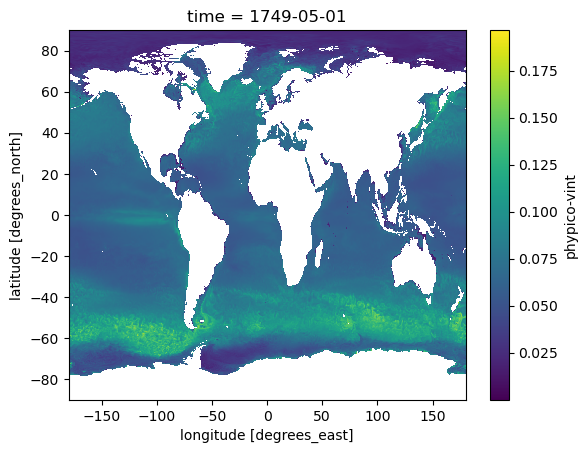

In [8]:
ds.isel(time = 100).plot()